In [11]:
import sys
sys.path.append('../')
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 15,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}

num_epochs = 50
print_every = 1

hidden_sizes1 = 128
hidden_sizes2 = 512
hidden_sizes3 = 128
num_hidden = 5

In [13]:
knot_types = {
	'standard_14': 0,  # 1
	'standard_16': 1,  # 2
	'standard_18': 2,  # 3
	'30both': 3,  # 4
	'30oneZ': 4,  # 5
	'optimized': 5,  # 6
	'pm_03_z': 6,  # 7
	'30oneX': 7,  # 11
    '15oneZ': 8,
    'dennis': 9,
    'trefoil_standard_16': 10,
    'trefoil_optimized': 11

}
knots = [
	'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
	'optimized', 'pm_03_z',
	'30oneX', '15oneZ', 'dennis',
    'trefoil_standard_16', 'trefoil_optimized'
]
folder = 'data_no_centers_135_13'


num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

Xs_list = []
Ys_list = []
for knot in knots:

    filename = f'../../../{folder}/data_{knot}_spectr.csv'
    # filename = f'../DATA/{folder}/data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            Ys_list.append(knot_types[knot])
            data_array = json.loads(row[0])
            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            Xs_list.append(np.abs(moments.reshape(-1)))


In [14]:
Xs_np = np.array(Xs_list)
ys_np = np.array(Ys_list)
# print(ys_np.shape)
Xs_torch = torch.tensor(Xs_np).float()
ys_t = torch.tensor(ys_np)
ys_torch = F.one_hot(ys_t.long(), num_classes=num_classes).float()
print(Xs_torch.shape, ys_torch.shape)

torch.Size([12000, 91]) torch.Size([12000, 12])


In [15]:
X_train, X_val_test, y_train, y_val_test = train_test_split(Xs_torch, ys_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [16]:

class ClassifierFC_spec(nn.Module):
    def __init__(self, input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3, num_hidden, num_classes):
        super(ClassifierFC_spec, self).__init__()
        layers = []
        # Create input layer
        layers.append(nn.Linear(input_size, hidden_sizes1))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes1, hidden_sizes2))
        layers.append(nn.ReLU())
        # Create hidden layers
        for i in range(0, num_hidden):
            layers.append(nn.Linear(hidden_sizes2, hidden_sizes2))
            layers.append(nn.ReLU())

        # Create output layer
        layers.append(nn.Linear(hidden_sizes2, hidden_sizes3))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes3, num_classes))
        # ModuleList of all layers
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            # print(x.shape)
        return x

In [17]:
# in_channels, out_channels, kernel_size, stride, padding
input_size = Xs_np.shape[-1]

num_classes = ys_torch.shape[-1]
model = ClassifierFC_spec(input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3,
                          num_hidden, num_classes).to(device)

In [18]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:4][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch).shape)
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([3, 91])
torch.Size([3, 12])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          11,776
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 512]          66,048
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 512]         262,656
              ReLU-8                  [-1, 512]               0
            Linear-9                  [-1, 512]         262,656
             ReLU-10                  [-1, 512]               0
           Linear-11                  [-1, 512]         262,656
             ReLU-12                  [-1, 512]               0
           Linear-13                  [-1, 512]         262,656

In [19]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [20]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)



train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')

Progress:   2%|▏         | 1/50 [00:34<27:52, 34.14s/it]

Epoch 0 completed in 34.14 seconds
Epoch 0: Train Loss: 2.1458, Val Loss: 1.9693


Progress:   4%|▍         | 2/50 [01:06<26:16, 32.84s/it]

Epoch 1 completed in 31.93 seconds
Epoch 1: Train Loss: 1.8573, Val Loss: 1.8620


Progress:   6%|▌         | 3/50 [01:39<26:04, 33.28s/it]

Epoch 2 completed in 33.81 seconds
Epoch 2: Train Loss: 1.7603, Val Loss: 1.8731


Progress:   8%|▊         | 4/50 [02:17<26:44, 34.88s/it]

Epoch 3 completed in 37.33 seconds
Epoch 3: Train Loss: 1.7229, Val Loss: 1.7039


Progress:  10%|█         | 5/50 [02:52<26:19, 35.09s/it]

Epoch 4 completed in 35.46 seconds
Epoch 4: Train Loss: 1.6872, Val Loss: 1.6754


Progress:  12%|█▏        | 6/50 [03:25<25:15, 34.44s/it]

Epoch 5 completed in 33.17 seconds
Epoch 5: Train Loss: 1.6619, Val Loss: 1.9007


Progress:  14%|█▍        | 7/50 [03:58<24:13, 33.80s/it]

Epoch 6 completed in 32.47 seconds
Epoch 6: Train Loss: 1.6465, Val Loss: 1.6431


Progress:  16%|█▌        | 8/50 [04:31<23:31, 33.61s/it]

Epoch 7 completed in 33.23 seconds
Epoch 7: Train Loss: 1.6162, Val Loss: 1.6530


Progress:  18%|█▊        | 9/50 [05:04<22:45, 33.29s/it]

Epoch 8 completed in 32.59 seconds
Epoch 8: Train Loss: 1.5832, Val Loss: 1.6441


Progress:  20%|██        | 10/50 [05:37<22:18, 33.47s/it]

Epoch 9 completed in 33.86 seconds
Epoch 9: Train Loss: 1.5425, Val Loss: 1.5558


Progress:  22%|██▏       | 11/50 [06:09<21:17, 32.76s/it]

Epoch 10 completed in 31.14 seconds
Epoch 10: Train Loss: 1.4959, Val Loss: 1.5239


Progress:  24%|██▍       | 12/50 [06:39<20:18, 32.07s/it]

Epoch 11 completed in 30.49 seconds
Epoch 11: Train Loss: 1.4572, Val Loss: 1.4694


Progress:  26%|██▌       | 13/50 [07:10<19:33, 31.73s/it]

Epoch 12 completed in 30.94 seconds
Epoch 12: Train Loss: 1.4130, Val Loss: 1.4488


Progress:  28%|██▊       | 14/50 [07:41<18:53, 31.48s/it]

Epoch 13 completed in 30.91 seconds
Epoch 13: Train Loss: 1.3737, Val Loss: 1.7282


Progress:  30%|███       | 15/50 [08:12<18:21, 31.48s/it]

Epoch 14 completed in 31.49 seconds
Epoch 14: Train Loss: 1.3510, Val Loss: 1.4563


Progress:  32%|███▏      | 16/50 [08:44<17:53, 31.56s/it]

Epoch 15 completed in 31.75 seconds
Epoch 15: Train Loss: 1.3199, Val Loss: 1.4548


Progress:  34%|███▍      | 17/50 [09:17<17:38, 32.08s/it]

Epoch 16 completed in 33.27 seconds
Epoch 16: Train Loss: 1.2934, Val Loss: 1.3894


Progress:  36%|███▌      | 18/50 [09:48<16:53, 31.68s/it]

Epoch 17 completed in 30.76 seconds
Epoch 17: Train Loss: 1.2673, Val Loss: 1.4514


Progress:  38%|███▊      | 19/50 [10:20<16:23, 31.73s/it]

Epoch 18 completed in 31.85 seconds
Epoch 18: Train Loss: 1.2494, Val Loss: 1.4112


Progress:  40%|████      | 20/50 [10:51<15:47, 31.57s/it]

Epoch 19 completed in 31.21 seconds
Epoch 19: Train Loss: 1.2360, Val Loss: 1.3234


Progress:  42%|████▏     | 21/50 [11:24<15:28, 32.01s/it]

Epoch 20 completed in 33.01 seconds
Epoch 20: Train Loss: 1.2082, Val Loss: 1.3431


Progress:  44%|████▍     | 22/50 [11:58<15:06, 32.37s/it]

Epoch 21 completed in 33.20 seconds
Epoch 21: Train Loss: 1.1916, Val Loss: 1.3813


Progress:  46%|████▌     | 23/50 [12:31<14:45, 32.81s/it]

Epoch 22 completed in 33.84 seconds
Epoch 22: Train Loss: 1.1682, Val Loss: 1.2901


Progress:  48%|████▊     | 24/50 [13:06<14:30, 33.48s/it]

Epoch 23 completed in 35.04 seconds
Epoch 23: Train Loss: 1.1504, Val Loss: 1.2699


Progress:  50%|█████     | 25/50 [13:41<14:05, 33.80s/it]

Epoch 24 completed in 34.56 seconds
Epoch 24: Train Loss: 1.1393, Val Loss: 1.2895


Progress:  52%|█████▏    | 26/50 [14:16<13:43, 34.32s/it]

Epoch 25 completed in 35.51 seconds
Epoch 25: Train Loss: 1.1095, Val Loss: 1.2919


Progress:  54%|█████▍    | 27/50 [14:52<13:18, 34.71s/it]

Epoch 26 completed in 35.64 seconds
Epoch 26: Train Loss: 1.0961, Val Loss: 1.2622


Progress:  56%|█████▌    | 28/50 [15:28<12:51, 35.07s/it]

Epoch 27 completed in 35.89 seconds
Epoch 27: Train Loss: 1.0801, Val Loss: 1.3583


Progress:  58%|█████▊    | 29/50 [16:03<12:16, 35.08s/it]

Epoch 28 completed in 35.12 seconds
Epoch 28: Train Loss: 1.0665, Val Loss: 1.3189


Progress:  60%|██████    | 30/50 [16:39<11:46, 35.35s/it]

Epoch 29 completed in 35.97 seconds
Epoch 29: Train Loss: 1.0395, Val Loss: 1.4765


Progress:  62%|██████▏   | 31/50 [17:15<11:12, 35.41s/it]

Epoch 30 completed in 35.55 seconds
Epoch 30: Train Loss: 1.0263, Val Loss: 1.2707


Progress:  64%|██████▍   | 32/50 [17:51<10:40, 35.61s/it]

Epoch 31 completed in 36.07 seconds
Epoch 31: Train Loss: 1.0120, Val Loss: 1.3588


Progress:  66%|██████▌   | 33/50 [18:27<10:08, 35.77s/it]

Epoch 32 completed in 36.14 seconds
Epoch 32: Train Loss: 0.9889, Val Loss: 1.3324


Progress:  68%|██████▊   | 34/50 [19:04<09:41, 36.32s/it]

Epoch 33 completed in 37.59 seconds
Epoch 33: Train Loss: 0.9747, Val Loss: 1.2942


Progress:  70%|███████   | 35/50 [19:42<09:09, 36.64s/it]

Epoch 34 completed in 37.40 seconds
Epoch 34: Train Loss: 0.9496, Val Loss: 1.4059


Progress:  72%|███████▏  | 36/50 [20:19<08:34, 36.78s/it]

Epoch 35 completed in 37.10 seconds
Epoch 35: Train Loss: 0.9379, Val Loss: 1.3125


Progress:  74%|███████▍  | 37/50 [20:56<07:58, 36.77s/it]

Epoch 36 completed in 36.75 seconds
Epoch 36: Train Loss: 0.9158, Val Loss: 1.3444


Progress:  76%|███████▌  | 38/50 [21:32<07:21, 36.76s/it]

Epoch 37 completed in 36.73 seconds
Epoch 37: Train Loss: 0.8995, Val Loss: 1.3391


Progress:  78%|███████▊  | 39/50 [22:09<06:43, 36.68s/it]

Epoch 38 completed in 36.50 seconds
Epoch 38: Train Loss: 0.8876, Val Loss: 1.3325


Progress:  80%|████████  | 40/50 [22:47<06:09, 36.96s/it]

Epoch 39 completed in 37.62 seconds
Epoch 39: Train Loss: 0.8666, Val Loss: 1.3567


Progress:  82%|████████▏ | 41/50 [23:24<05:32, 36.98s/it]

Epoch 40 completed in 37.02 seconds
Epoch 40: Train Loss: 0.8480, Val Loss: 1.4339


Progress:  84%|████████▍ | 42/50 [24:00<04:54, 36.87s/it]

Epoch 41 completed in 36.61 seconds
Epoch 41: Train Loss: 0.8217, Val Loss: 1.3761


Progress:  86%|████████▌ | 43/50 [24:37<04:18, 36.99s/it]

Epoch 00043: reducing learning rate of group 0 to 2.0000e-05.
Epoch 42 completed in 37.28 seconds
Epoch 42: Train Loss: 0.8067, Val Loss: 1.4532


Progress:  88%|████████▊ | 44/50 [25:15<03:42, 37.13s/it]

Epoch 43 completed in 37.44 seconds
Epoch 43: Train Loss: 0.6371, Val Loss: 1.5191


Progress:  90%|█████████ | 45/50 [25:52<03:05, 37.19s/it]

Epoch 44 completed in 37.34 seconds
Epoch 44: Train Loss: 0.5918, Val Loss: 1.6459


Progress:  92%|█████████▏| 46/50 [26:29<02:28, 37.19s/it]

Epoch 45 completed in 37.20 seconds
Epoch 45: Train Loss: 0.5701, Val Loss: 1.7378


Progress:  94%|█████████▍| 47/50 [27:08<01:52, 37.47s/it]

Epoch 46 completed in 38.10 seconds
Epoch 46: Train Loss: 0.5547, Val Loss: 1.7028


Progress:  96%|█████████▌| 48/50 [27:45<01:14, 37.40s/it]

Epoch 47 completed in 37.23 seconds
Epoch 47: Train Loss: 0.5403, Val Loss: 1.7951


Progress:  98%|█████████▊| 49/50 [28:22<00:37, 37.47s/it]

Epoch 48 completed in 37.63 seconds
Epoch 48: Train Loss: 0.5256, Val Loss: 1.8927


Progress: 100%|██████████| 50/50 [29:00<00:00, 34.82s/it]

Epoch 49 completed in 37.90 seconds
Epoch 49: Train Loss: 0.5086, Val Loss: 1.9053
Total training time: 1740.83 seconds


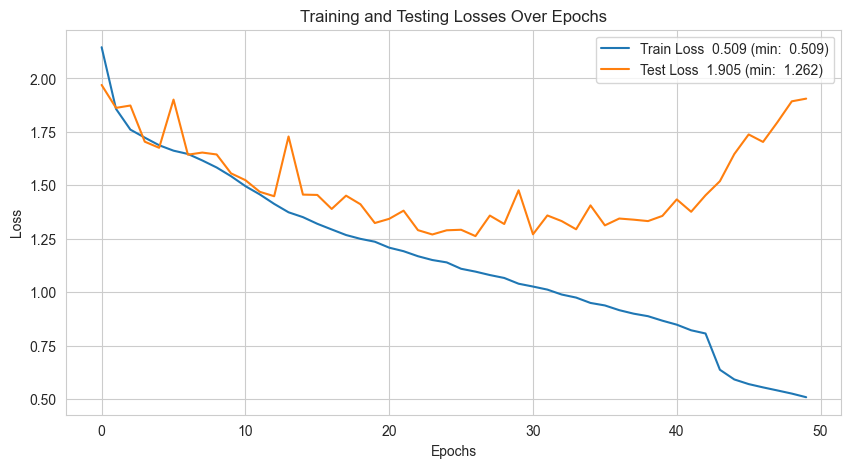

In [21]:
plot_losses(train_losses, val_losses, decimals=3)

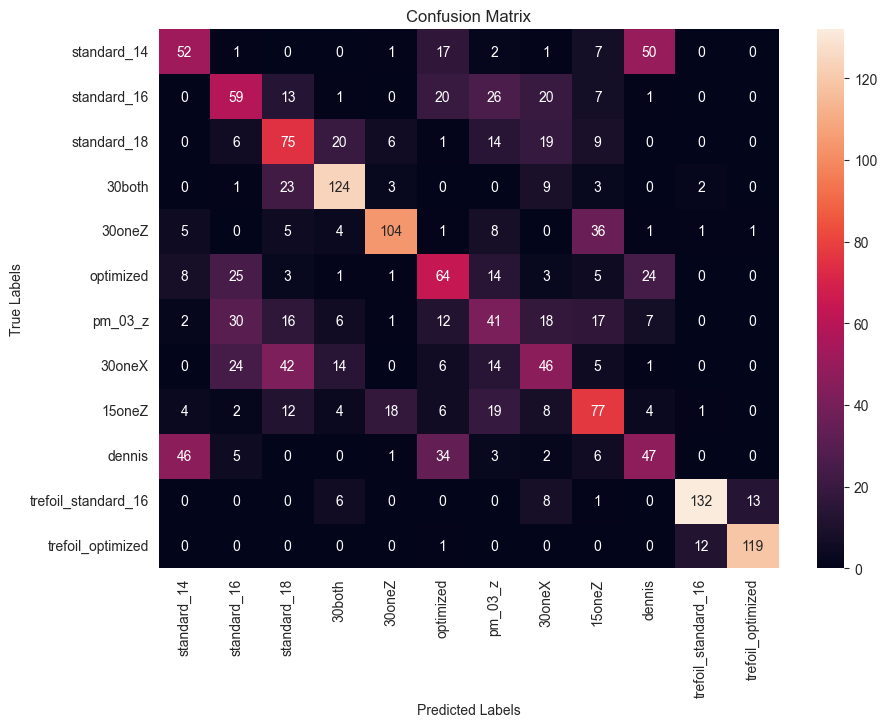

In [22]:
# predictions = model(X_torch.to(device))
# predictions
_, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.5222222222222223


In [24]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 940/1800
Number of correct predictions (val): 920/1800


Creating the least of the weights in 2D as a basis

In [25]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

FileNotFoundError: [Errno 2] No such file or directory: '..\\data_no_centers_135_13\\data_standard_14_spectr.csv'

In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)